<h1 style="text-align: center;">Simulación y aplicaciones en ciencias sociales y experimentales
</h3>
<h3 style="text-align: center;"> Tema 2.2 Modelos deterministas de segundo orden </h3>
<h3 style="text-align: center;"> Ejercicios </h3>

### Ejercicio 1 

En medicina, es importante conocer lo rápido que la droga entra en la sangre y cómo esa concentración evoluciona en el tiempo. 

Este modelo explica de una forma simple este fenómeno. Vamos a considerar dos variables de estado: $G(t)$, que representa la concentración de droga en el tracto intestinal en el tiempo $t$, y $B(t)$, que indica la concentración de droga en la sangre (en microgramos por ml). Si se suministra una dosis vía oral de $D(t)$ microgramos por ml, la dinámica del sistema se puede describir de la siguiente manera: 

$$\begin{array}{l} \displaystyle{\dot{G}} = -aG+D(t),\\ \displaystyle{\dot{B}} = aG-bB,\end{array}$$

donde $a$ y $b$ son parámetros positivos. Por tanto, estas ecuaciones indican que cada periodo de tiempo (horas) un porcentaje $a$ de la droga en el tracto digestivo se incorpora a la concentración de droga en sangre, mientras que en el mismo periodo de tiempo un porcentaje $b$ de la droga en sangre decae y desaparece. 

**(a)** Simular la cantidad de droga en el tracto y en sangre en 72 horas. La droga se suministra en una toma cada 6 horas de 2 microgramos por ml. Asumir inicialmente $a=\ln(2)/2$, y $b=\ln(2)/5$, que son los parámetros sugeridos por la literatura.  

**(b)** Tras el suministro de la dosificación a una persona determinada, se observó que la concentración en sangre de esa droga oscilaba entre unos valores de 3.4 y 4.5 microgramos por ml. Ajustar los parámetros del modelo para que la simulación en el equilibrio alcance esos valores. 

In [32]:
import numpy as np
import matplotlib.pyplot as plt

a = np.log(2)/2
b = np.log(2)/5

In [33]:
def model(a, b, administer):
    def f(x,t):
        return np.array([
            -a*x[0] + administer(t),
            +a*x[0] - b*x[1]
        ])
    return f

def administer(dt):
    def a(t):
        if (t % 6) < 0.0001:
            return 2/dt
        return 0
    return a

In [1]:
def solve_ode(model, x0, t):
    n = len(t)
    x = np.zeros((n, len(x0)))
    x[0] = x0
    for i in range(n-1):
        dt = t[i+1] - t[i]
        x[i+1] = x[i] + dt * model(x[i], t[i])
    return x

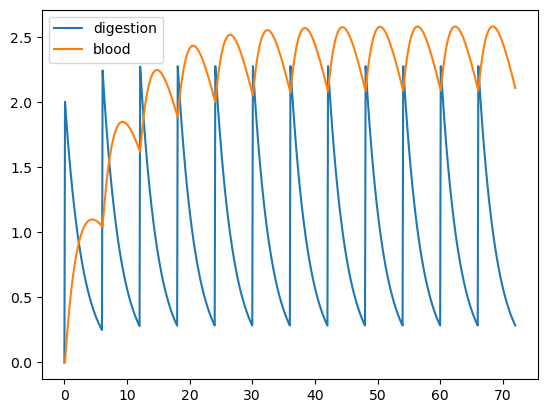

In [35]:
dt = 0.1
t = np.linspace(0, 72, int(72/dt+1))

x0 = np.zeros(2)

x = solve_ode(model(a, b, administer(dt)), x0, t)

plt.plot(t, x[:,0], label="digestion")
plt.plot(t, x[:,1], label="blood")
plt.legend()
plt.show()

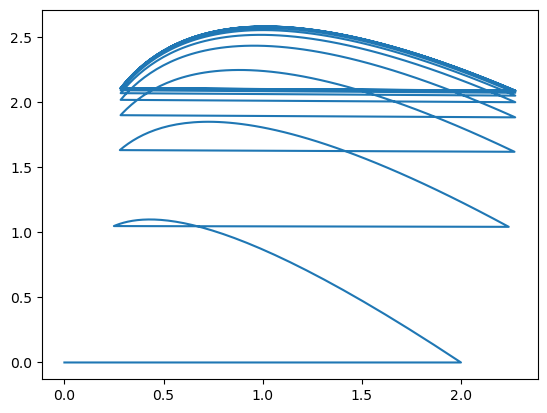

In [36]:
plt.plot(x[:,0], x[:,1])

In [37]:
x.shape[0]

721

In [38]:
from scipy.optimize import leastsq

def error(params):
    x = solve_ode(model(params[0], params[1], administer(dt)), x0, t)
    stable = int(x.shape[0] * (2/3))
    blood_stable = x[stable:, 1]
    blood_min = np.min(blood_stable)
    blood_max = np.max(blood_stable)

    return np.array([
        blood_min - 3.4,
        blood_max - 4.5
    ])

(a_hat, b_hat), _ = leastsq(error, np.array([a, b]))
a_hat, b_hat

(np.float64(0.926866885752828), np.float64(0.08115979316121791))

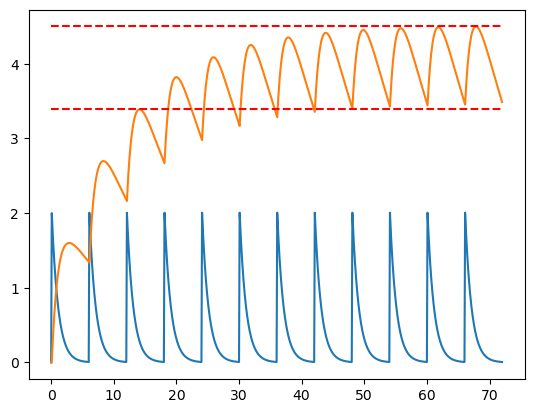

In [39]:
x_hat = solve_ode(model(a_hat, b_hat, administer(dt)), x0, t)

plt.plot(t, x_hat)
plt.hlines([3.4, 4.5], 0, 72, 'r', 'dashed')
plt.show()

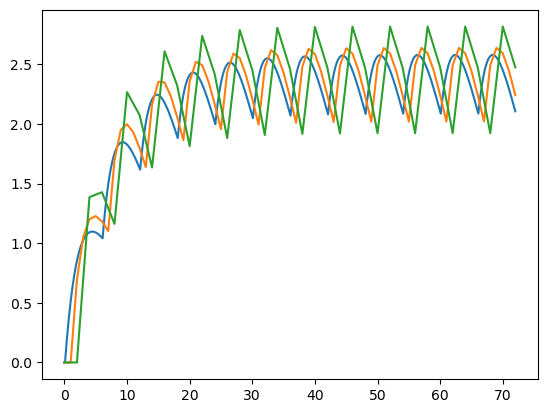

In [40]:
tss = [0.1, 1, 2]

for ts in tss:
    t_ts = np.linspace(0, 72, int(72/ts+1))
    x_ts = solve_ode(model(a, b, administer(ts)), x0, t_ts)
    plt.plot(t_ts, x_ts[:,1])

### Ejercicio 2

El siguiente modelo propone representar el proceso de regulación de la glucosa en sangre a través de la producción de insulina. Para ello seguiremos el denominado **modelo mínimo** (más detalles en [Bergman et al, 2006](https://journals.physiology.org/doi/abs/10.1152/ajpendo.1979.236.6.E667), modelo VI), que asume dos hipótesis:

1. La glucosa, una vez introducida en sangre, vuelve a sus niveles basales debido a dos efectos: reducción natural de la concentración de glucosa y el efecto de la insulina.
2. La insulina no actúa directamente, sino que primero se desplaza de la sangre al fluido que rodea al tejido celular y de ahí actúa sobre la glucosa.

El modelo mínimo consiste en dos ecuaciones diferenciales:

$$\begin{array}{l}\displaystyle{\dot{G}} = -k_1 \left[ G(t) - G_b \right] - X(t) G(t),\\
\displaystyle{\dot{X}} = k_3 \left[I(t) - I_b \right] - k_2 X(t),\end{array}$$ 

donde $G$ y $X$ son las concentraciones de glucosa en sangre y de insulina en el fluido del tejido celular, respectivamente. La función $I(t)$ indica la concentración de insulina en sangre, que tomamos exógena. Los parámetros $G_b$ e $I_b$ son los niveles basales de glucosa e insulina en sangre, mientras que $k_1$, $k_2$ y $k_3$ son parámetros positivos que controlan las tasas de decaemiento de glucosa e insulina. Los datos que se encuentran en este [archivo](https://github.com/AllenDowney/ModSim/raw/main/data/glucose\_insulin.csv) indican la concentración en sangre de glucosa e insulina medidos durante 182 minutos a un paciente normal.

**(a)** Estimar la concentración de glucosa en sangre a través del modelo.  En la simulación tomar como datos iniciales $k_1 = 0.02$,  $k_2 = 0.02$, $k_3 = 1.5e-05$, y unos niveles iniciales $G_0=270$ y $X_0=0$. Los niveles basales de glucosa e insulina en sangre son los iniciales de los datos reales. En la simulación es necesario interpolar los datos reales de concentración de insulina para cada minuto.

**(b)** Hallar los valores de los parámetros $k_1$, $k_2$ y $k_3$ con los que se obtenga el mejor ajuste de la simulación de la concentración de glucosa en sangre a los datos reales. Para el ajuste tomar los datos a partir de la cuarta toma de glucosa.

In [117]:
import pandas as pd

k1 = 0.02
k2 = 0.02
k3 = 1.5e-5
G0 = 270
X0 = 0

insulin_df = pd.read_csv("glucose_insulin.csv")

Gb = insulin_df["glucose"].iloc[0]
Ib = insulin_df["insulin"].iloc[0]

insulin_df.head()

,time,glucose,insulin
0,0,92,11
1,2,350,26
2,4,287,130
3,6,251,85
4,8,240,51


In [114]:
def insulin_model(k1, k2, k3, Gb, Ib, insulin):
    def f(x, t):
        return np.array([
            k1 * (Gb - x[0] ) - x[1] * x[0],
            k3 * (insulin(t) - Ib) - k2*x[1]
        ])
    return f

def insulin(t):
    last = insulin_df[insulin_df["time"] <= t].iloc[-1]
    next = insulin_df[insulin_df["time"] > t].iloc[0]

    t_l = last["time"]
    t_n = next["time"]

    f = (t - t_l) / (t_n - t_l)

    i_l = last["insulin"]
    i_n = next["insulin"]

    return i_n * f + i_l *(1-f)


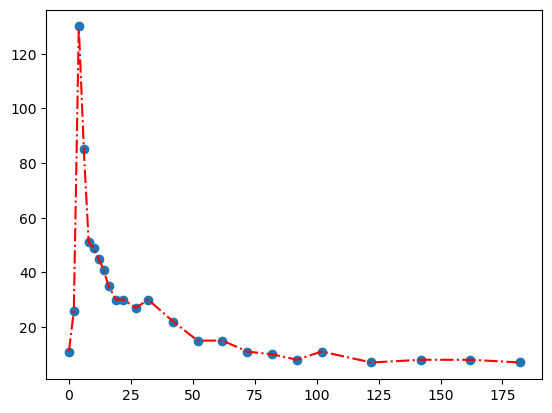

In [108]:
t = np.linspace(0, 181, 182*5)
i = np.array([insulin(x) for x in t])
plt.plot(t, i, '-.r')
plt.scatter(insulin_df["time"], insulin_df["insulin"])

In [ ]:
dt = 1
t = np.linspace(0, 181, int(181/dt+1))

x = solve_ode(insulin_model(k1, k2, k3, Gb, Ib, insulin), np.array([G0, X0]), t)x

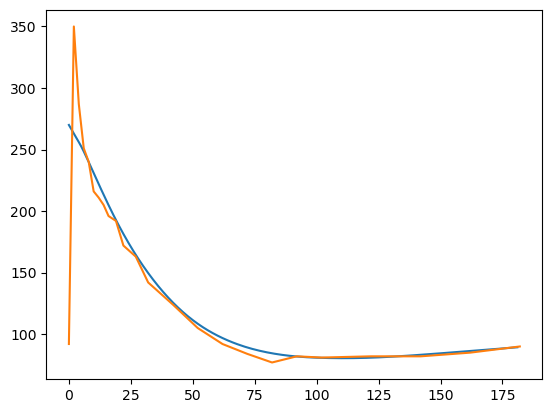

In [122]:
plt.plot(t, x[:,0])
plt.plot(insulin_df["time"], insulin_df["glucose"])